In [26]:
import datetime

import cvxpy as cp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from elarb import datasets, util

In [11]:
datasets.download_nordpool('2020-10-09', '2020-10-11')

,HourUTC,HourDK,PriceArea,SpotPriceDKK,SpotPriceEUR,dt,h
0,2020-10-08 22:00:00,2020-10-09 00:00:00,DK2,78.889999,10.600000,2020-10-09,0
1,2020-10-08 23:00:00,2020-10-09 01:00:00,DK2,65.860001,8.850000,2020-10-09,1
2,2020-10-09 00:00:00,2020-10-09 02:00:00,DK2,64.300003,8.640000,2020-10-09,2
3,2020-10-09 01:00:00,2020-10-09 03:00:00,DK2,66.610001,8.950000,2020-10-09,3
4,2020-10-09 02:00:00,2020-10-09 04:00:00,DK2,96.529999,12.970000,2020-10-09,4
5,2020-10-09 03:00:00,2020-10-09 05:00:00,DK2,89.010002,11.960000,2020-10-09,5
6,2020-10-09 04:00:00,2020-10-09 06:00:00,DK2,159.710007,21.459999,2020-10-09,6
7,2020-10-09 05:00:00,2020-10-09 07:00:00,DK2,283.480011,38.090000,2020-10-09,7
8,2020-10-09 06:00:00,2020-10-09 08:00:00,DK2,392.059998,52.680000,2020-10-09,8
9,2020-10-09 07:00:00,2020-10-09 09:00:00,DK2,400.989990,53.880001,2020-10-09,9


## Load data

In [2]:
#df = datasets.download_nordpool('2022-10-09', '2022-10-11')
#df = df[df.HourDK >= '2022-10-09 12:00:00'].reset_index()
#df.to_csv('../data/example.csv', index=False)
df = pd.read_csv('../data/example.csv')
spot_dkk = df.SpotPriceDKK.values / 1000.0
spot_dkk

array([0.44604001, 0.37189002, 0.40722   , 0.38260001, 0.98460999,
       1.36169995, 1.47892004, 1.92443994, 1.07883997, 0.70509998,
       0.68940002, 0.45995001, 0.51596002, 0.40185998, 0.07274   ,
       0.06716   , 0.07088   , 0.08412   , 0.95025   , 1.69030005,
       1.98036999, 1.61532996, 1.22744995, 1.18163   , 0.99264001,
       0.97494   , 0.97560999, 1.03659998, 1.18156006, 1.56623999,
       1.84315002, 2.05832007, 1.33432996, 1.17464002, 1.15581995,
       0.89945001])

## Optimal policy

```
           ┌───────┐       
    ┌─x1──▶│ Grid  │──┐    
    │      └───────┘  │    
┌───────┐      ▲      │    
│ Solar │      │x3    │x4    
└───────┘      │      │    
    │      ┌───────┐  │    
    └─x2──▶│Battery│◀─┘    
           └───────┘       
```

### Parameters

In [4]:
n = len(spot_dkk)

# 1 inverter: Deye SUN-12K-SG04LP3-EU
# ... ignored

# grid
standard_outlet_kWh = 12.8
d_grid = cp.Parameter(n, nonneg=True)
d_grid.value = np.zeros(n) + standard_outlet_kWh
s_grid = cp.Parameter(n, nonneg=True)
s_grid.value = np.zeros(n) + standard_outlet_kWh

# 3 battery: Powerwall LBATTS Powerwall, 8.8 kwh
bat_cap = 26.4
bat_discharge = 11.52
bat_depreciation = 0.4
bat_loss = 0.03
bat_SoC = ... # defined later

# 33 solar panels: 470Wp JinKO TigerNeo N-Type 60HL4 BF, 1.57 kWh / time
solar_kWh = 1.57
solar_depreciation = 0.16
s_solar = cp.Parameter(n, nonneg=True)
s_solar.value = np.zeros(n) + solar_kWh

# prices
p_x1 = cp.Parameter(n)
p_x1.value = np.zeros(n) + spot_dkk - solar_depreciation 

p_x2 = cp.Parameter(n)
p_x2.value = np.zeros(n) - solar_depreciation # - bat_depreciation

p_x3 = cp.Parameter(n)
p_x3.value = np.zeros(n) + spot_dkk - bat_depreciation

p_x4 = cp.Parameter(n)
p_x4.value = np.zeros(n) - spot_dkk # - bat_depreciation

### Variables

In [6]:
x1 = cp.Variable(n, nonneg=True)
x2 = cp.Variable(n, nonneg=True)
x3 = cp.Variable(n, nonneg=True)
x4 = cp.Variable(n, nonneg=True)

### Objective function

In [7]:
contrib_x1 = p_x1@x1
contrib_x2 = p_x2@x2
contrib_x3 = p_x3@x3
contrib_x4 = p_x4@x4
objective = cp.Maximize(cp.sum(contrib_x1 + contrib_x2 + contrib_x3 + contrib_x4))

### Constraints

```
           ┌───────┐       
    ┌─x1──▶│ Grid  │──┐    
    │      └───────┘  │    
┌───────┐      ▲      │    
│ Solar │      │x3    │x4    
└───────┘      │      │    
    │      ┌───────┐  │    
    └─x2──▶│Battery│◀─┘    
           └───────┘       
```

In [8]:
# TODO: plug in battery loss somewhere... in bat_SoC
charge_loss = 0.97
bat_soc = cp.cumsum(x2*charge_loss + x4*charge_loss - x3)
d_bat = bat_cap - bat_soc

constraints = [
    # sales to grid cannot exceed demand of grid
    x1 + x3 <= d_grid,
    # sales to bat cannot exceed demand (i.e. gap to full) of battery
    x2 + x4 <= d_bat,
    # buys from solar cannot exceed supply of solar
    x1 + x2 <= s_solar,
    # sells from battery cannot exceed maximum discharge
    x3 <= bat_discharge,
    # sells from battery cannot exceed state of charge (SoC)  
    x3 <= bat_soc,
    # buys from grid cannot exceed supply of grid
    x4 <= s_grid,
    # SoC cannot exceed battery capacity, i.e. the max over cumulative sum of battery flow cannot exceed capacity 
    cp.max(bat_soc) <= bat_cap
]

### Solve problem

Solar only = 46.44 DKK
Solar + arbitrage = 101.01 DKK
- Solar to grid (x1) = 43.46 DKK
- Solar to battery (x2) = -1.05 DKK
- Battery to grid (x3) = 87.81 DKK
- Grid to battery (x4) = -29.21 DKK
- Check:  101.01 DKK




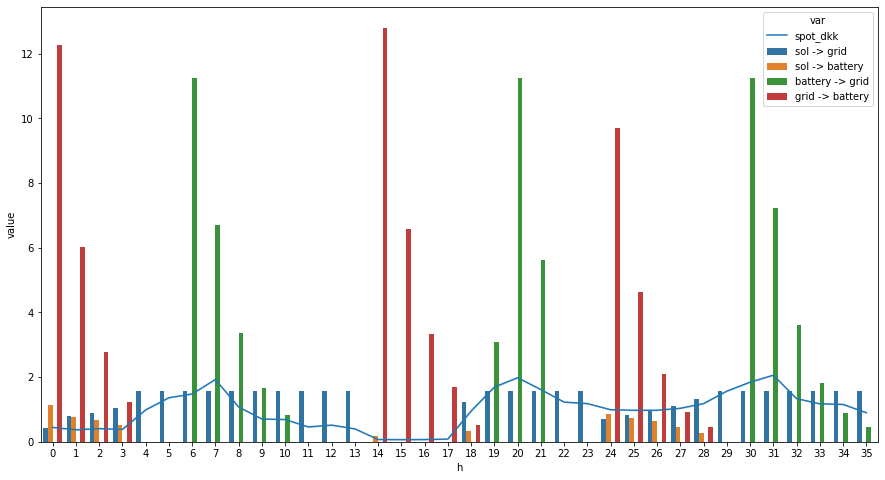

In [40]:
prob = cp.Problem(objective, constraints)
result = prob.solve()
result_solaronly = np.round(cp.sum(s_solar@p_x1).value, 2)
result_solar_and_arb = np.round(result, 2)

x1_component = cp.sum(x1@p_x1).value.round(2)
x2_component = cp.sum(x2@p_x2).value.round(2)
x3_component = cp.sum(x3@p_x3).value.round(2)
x4_component = cp.sum(x4@p_x4).value.round(2)

print('Solar only =', result_solaronly, 'DKK')
print('Solar + arbitrage =', result_solar_and_arb, 'DKK')
print('- Solar to grid (x1) =', x1_component, 'DKK')
print('- Solar to battery (x2) =', x2_component, 'DKK')
print('- Battery to grid (x3) =', x3_component, 'DKK')
print('- Grid to battery (x4) =', x4_component, 'DKK')
print('- Check: ', np.round(x1_component + x2_component + x3_component + x4_component, 2), 'DKK')
print()
#print('Solar to grid:', x1.value.round(3), 'maximum:', max(x1.value.round(3)))
#print('Solar to battery:', x2.value.round(3), 'maximum:', max(x2.value.round(3)))
#print('Battery to grid:', x3.value.round(3), 'maximum:', max(x3.value.round(3)))
#print('Grid to battery:', x4.value.round(3), 'maximum:', max(x4.value.round(3)))
#print(np.round(constraints[0].dual_value, 2))
print()

h = list(range(n))
p = spot_dkk.tolist()
df_plot = pd.DataFrame({
    'h': h+h+h+h,
    'p': p+p+p+p,
    'value': (
        x1.value.tolist()
        +x2.value.tolist()
        +x3.value.tolist()
        +x4.value.tolist()),
    'var': (
        ['sol -> grid']*n
        + ['sol -> battery']*n
        + ['battery -> grid']*n
        + ['grid -> battery']*n
    )
})
plt.figure(figsize=(15,8))
sns.lineplot(data=df_plot, x='h', y='p', label='spot_dkk')
sns.barplot(data=df_plot, x='h', y='value', hue='var')
plt.show()